In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
%matplotlib inline

## Define functions to rotate velocities

In [2]:
import math

def rotate(x,y,xo,yo,theta): #rotate x,y around xo,yo by theta (rad)
    xr=math.cos(theta)*(x-xo)-math.sin(theta)*(y-yo)   + xo
    yr=math.sin(theta)*(x-xo)+math.cos(theta)*(y-yo)  + yo
    return [xr,yr]

## load test dataset

/home/z3526974/anaconda2/lib/python2.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


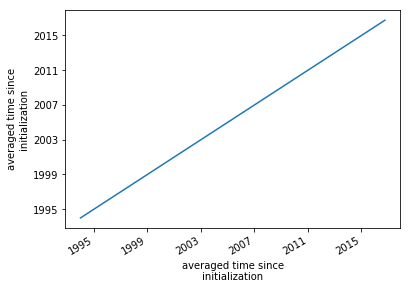

In [3]:
fname = '/home/z3526974/Work/data/EAC_roms/EAC_roms_22yr_SSH_remapped.nc'
ds = xr.open_dataset(fname)
ds.ocean_time.plot()


## Define line for Hovmoller - make plot to show where it is

In [4]:
start_lon = 154
start_lat = -31

end_lon = 150.6
end_lat = -36.4

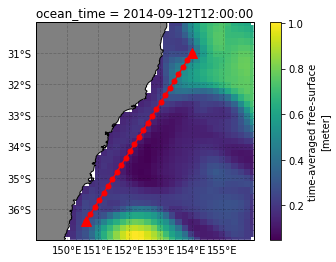

In [5]:
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

ax1 = plt.axes(projection=ccrs.PlateCarree())
feature = ax1.add_feature(coast, edgecolor='black',facecolor='gray')
ds.zeta.sel(ocean_time = '2014-09-12').plot(transform=ccrs.PlateCarree())
plt.plot(start_lon, start_lat, color='red', marker='^',markersize = 10,transform=ccrs.PlateCarree())
plt.plot(end_lon, end_lat, color='red', marker='^',markersize = 10,transform=ccrs.PlateCarree())
ax1.set_extent([149, 156, -37, -30])
gl = ax1.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top = False

#make array of lats and lons for slicing
path_lats=np.linspace(start_lat,end_lat, 25)
path_lons=np.linspace(start_lon,end_lon, 25)
plt.plot(path_lons, path_lats, color='red', marker='o',markersize = 5)
#plt.savefig('dipole_section_location.png', dpi=300,bbox_inches='tight')

## Extract section along this line for Hovmoller

In [6]:
# use xarray advanced interpolation interp - can't seem to do this pairwise for latlon pairs, for the moment doing it in a loop
section = []
for x in range(25):
    px = ds.sel(LATITUDE=path_lats[x], LONGITUDE=path_lons[x],method = 'nearest') 
    section.append(px)
sec = xr.concat(section, dim=path_lats)

    

ang = np.deg2rad(27)
#rotate velocities normal to section
[u_rot, v_rot]=rotate(sec.UCUR,sec.VCUR,0,0, ang) 


AttributeError: 'Dataset' object has no attribute 'UCUR'

In [7]:
plt.figure(figsize=(15, 5))
u_rot.plot(vmin=-.5,vmax=.5,cmap='RdBu_r')
plt.ylabel('Latitude [$^o$]')
plt.xlabel('Year')
#plt.savefig('dipole_hovemoller.png', dpi=300,bbox_inches='tight')

NameError: name 'u_rot' is not defined

<Figure size 1080x360 with 0 Axes>

## Plot time-mean of the Hovmoller

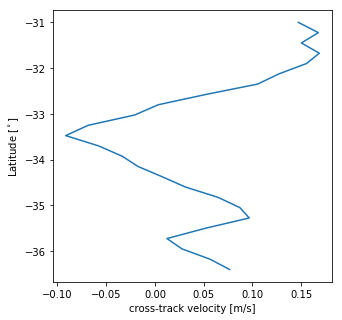

In [8]:
plt.figure(figsize=(5, 5))
u_rot.mean(axis = 1).plot(y='concat_dim')
plt.ylabel('Latitude [$^\circ$]')
plt.xlabel('cross-track velocity [m/s]')
#plt.savefig('dipole_hovemoller_mean.png', dpi=300,bbox_inches='tight')

## Get latitude of max onshore velocity at each timestep

In [9]:
u_rot.shape

(25, 9532)

In [10]:
onshore_lats=[]
for i in range(len(u_rot.TIME)):
    x = np.argmin(u_rot[:,i])
    ll = (x)
    onshore_lats.append(ll)
onshore_timeseries=path_lats[onshore_lats]

In [11]:
#get values at min of each column
ol=np.array(onshore_lats)
np.shape(ol)
onshore_u_min=u_rot[ol,:]

u_dipole=[]
for i in range(len(u_rot.TIME)):
    q = u_rot[ol[i],i]
    lll = (q)
    u_dipole.append(lll)
    

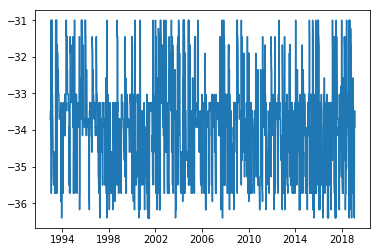

-33.92677035249686

In [12]:
mean_lat = np.mean(onshore_timeseries)
plt.plot(u_rot.TIME,onshore_timeseries)
plt.show()
mean_lat

In [13]:
onshore_lats = xr.concat(onshore_lats,dim='TIME')
onshore_lats

<xarray.DataArray (TIME: 9532)>
array([12, 12, 11, ..., 13, 13, 13])
Coordinates:
  * TIME     (TIME) datetime64[ns] 1993-01-01 1993-01-02 ... 2019-02-05

## Plot Histograms


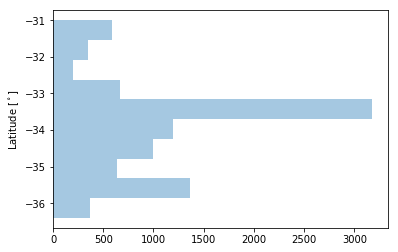

In [14]:
sns.distplot(onshore_timeseries,bins=10, vertical=True, kde=False);
plt.ylabel('Latitude [$^\circ$]')
#plt.savefig('dipole_histogram_no_threshold.png', dpi=300,bbox_inches='tight')

In [15]:
u_dipole = xr.concat(u_dipole,dim='TIME')
u_dipole

<xarray.DataArray (TIME: 9532)>
array([-0.21841 , -0.171864, -0.132934, ..., -0.189511, -0.224077, -0.197396])
Coordinates:
  * TIME        (TIME) datetime64[ns] 1993-01-01 1993-01-02 ... 2019-02-05
    LONGITUDE   (TIME) float32 152.4 152.4 152.4 152.4 ... 152.2 152.2 152.2
    LATITUDE    (TIME) float32 -33.8 -33.8 -33.4 -33.4 ... -34.0 -34.0 -34.0
    concat_dim  (TIME) float64 -33.7 -33.7 -33.48 ... -33.92 -33.92 -33.92

## Impose threshold

In [16]:
# create a categorical  dataarray
dip_index = xr.full_like(u_dipole, 'none', dtype='U6')
dip_index[u_dipole >= -.25] = 'normal'
dip_index[u_dipole <= -.25] = 'dipole'
dip_index

<xarray.DataArray (TIME: 9532)>
array([u'normal', u'normal', u'normal', ..., u'normal', u'normal', u'normal'],
      dtype='<U6')
Coordinates:
  * TIME        (TIME) datetime64[ns] 1993-01-01 1993-01-02 ... 2019-02-05
    LONGITUDE   (TIME) float32 152.4 152.4 152.4 152.4 ... 152.2 152.2 152.2
    LATITUDE    (TIME) float32 -33.8 -33.8 -33.4 -33.4 ... -34.0 -34.0 -34.0
    concat_dim  (TIME) float64 -33.7 -33.7 -33.48 ... -33.92 -33.92 -33.92

## plot composites using threshold

/home/z3526974/anaconda2/lib/python2.7/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


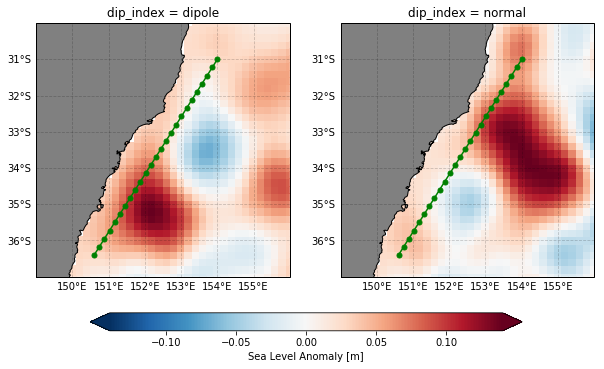

In [17]:
sla_dipole_composite = ds.GSLA.groupby(dip_index.rename('dip_index')).mean(dim='TIME')

coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1,projection=ccrs.PlateCarree())
feature = ax1.add_feature(coast, edgecolor='black',facecolor='gray')
im = sla_dipole_composite.sel(dip_index='dipole').plot(transform=ccrs.PlateCarree(),add_colorbar=False)
ax1.set_extent([149, 156, -37, -30])
gl = ax1.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top = False
plt.plot(path_lons, path_lats, color='green', marker='o',markersize = 5)

ax1 = plt.subplot(1,2,2,projection=ccrs.PlateCarree())
feature = ax1.add_feature(coast, edgecolor='black',facecolor='gray')
sla_dipole_composite.sel(dip_index='normal').plot(transform=ccrs.PlateCarree(),add_colorbar=False)
ax1.set_extent([149, 156, -37, -30])
gl = ax1.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top = False
plt.plot(path_lons, path_lats, color='green', marker='o',markersize = 5)

cbar_ax = fig.add_axes([0.2, -0.0, .6, .05]) #left, bottom, width, height
fig.colorbar(im, cax=cbar_ax, orientation="horizontal",extend='both')
plt.xlabel('Sea Level Anomaly [m]')
#plt.savefig('dipole_composite_025.png', dpi=300,bbox_inches='tight')
plt.show()

In [18]:
sla_dipole_composite.sel(dip_index='dipole').count()

<xarray.DataArray 'GSLA' ()>
array(815)
Coordinates:
    dip_index  <U6 u'dipole'

## plot histogram of dipole composite, need to convert u_dipole to a dataframe to do this

In [19]:
df = u_dipole.to_dataframe(name = 'U');

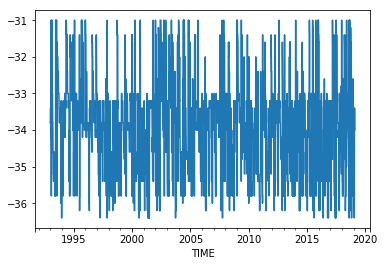

In [20]:
df.LATITUDE.plot()

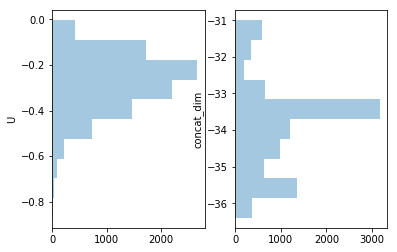

In [21]:
plt.subplot(1,2,1)
sns.distplot( df[ "U" ] ,bins=10, vertical = True, kde=False )
plt.subplot(1,2,2)
sns.distplot( df[ "concat_dim" ] ,bins=10, vertical = True, kde=False )

## Groupby threshold (in pandas this time)

In [32]:
dipole = df['U'] < -.25

TIME
1993-01-01   -33.700
1993-01-02   -33.700
1993-01-03   -33.475
1993-01-04   -33.475
1993-01-05   -33.475
1993-01-06   -33.475
1993-01-07   -33.475
1993-01-08   -34.150
1993-01-09   -34.150
1993-01-10   -34.150
1993-01-11   -34.150
1993-01-12   -34.150
1993-01-13   -34.150
1993-01-14   -34.150
1993-01-15   -34.150
1993-01-16   -34.150
1993-01-17   -34.150
1993-01-18   -31.000
1993-01-19   -31.000
1993-01-20   -34.150
1993-01-21   -34.150
1993-01-22   -34.375
1993-01-23   -34.375
1993-01-24   -34.375
1993-01-25   -34.375
1993-01-26   -34.375
1993-01-27   -35.725
1993-01-28   -35.725
1993-01-29   -35.725
1993-01-30   -35.725
               ...  
2019-01-07   -35.725
2019-01-08   -35.725
2019-01-09   -35.725
2019-01-10   -35.725
2019-01-11   -36.175
2019-01-12   -36.175
2019-01-13   -36.175
2019-01-14   -36.175
2019-01-15   -36.175
2019-01-16   -36.175
2019-01-17   -36.175
2019-01-18   -36.175
2019-01-19   -36.175
2019-01-20   -36.175
2019-01-21   -36.400
2019-01-22   -33.475
2019-01-

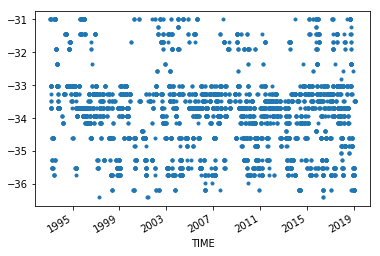

In [37]:
df[dipole].concat_dim.plot(style=".")

LONGITUDE     5195
LATITUDE      5195
concat_dim    5195
U             5195
dtype: int64

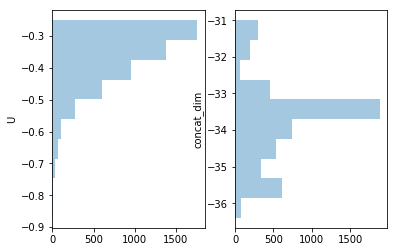

In [24]:
plt.subplot(1,2,1)
sns.distplot( df[dipole].U ,bins=10, vertical = True, kde=False )
plt.subplot(1,2,2)
sns.distplot( df[dipole].concat_dim ,bins=10, vertical = True, kde=False )
df[dipole].count()

## Load SST data

In [25]:
fname = '/home/z3526974/Work/data/dipole_work/IMOS_SST_1993_2019/IMOS_aggregation_20190314T220014Z.nc'
sst = xr.open_dataset(fname)

In [26]:
sst.sea_surface_temperature[[1,2,4],:,:]



<xarray.DataArray 'sea_surface_temperature' (time: 3, lat: 100, lon: 100)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -32.01 -32.03 -32.05 -32.07 ... -33.95 -33.97 -33.99
  * lon      (lon) float32 151.01 151.03 151.05 151.07 ... 152.95 152.97 152.99
  * time     (time) datetime64[ns] 1992-03-24T15:20:00 ... 1992-03-29T15:20:00
Attributes:
    long_name:      sea surface skin temperature
    units:          kelvin
    standard_name:  sea_surface_skin_temperature
    valid_min:      -53.45831
    valid_max:      601.88